## **Tutorial Overview: Comparing Active Learning Strategies with scikit-activeml**

This tutorial aims to demonstrate a practical comparison study using the 'scikit-activeml' library. The workflow involves utilizing a self-supervised learning model, specifically DINOv2 from [1], to generate embeddings for the CIFAR-10, CIFAR-100, and Flowers-102 datasets. Subsequently, various active learning strategies will be employed to intelligently select samples for labeling.

**Key Steps:**
1. **Self-Supervised Learning Model:** Utilize the DINOv2 model to create embedding datasets for CIFAR-10, CIFAR-100, and Flowers-102 datasets.

2. **Active Learning Strategies:** Employ different active learning strategies provided by the scikit-activeml library, including:
    - Random Sampling
    - Uncertainty Sampling
    - Discriminative Active Learning (DiscriminativeAL)
    - CoreSet
    - TypiClust
    - Badge

3. **Labeling Selection:** Use each active learning strategy to select specific samples for labeling, exploring diverse approaches to guide the learning process.

4. **Logging Results with mlflow:** Record and track the results obtained from each active learning strategy using mlflow [2], a platform for managing the complete machine learning lifecycle.

**References:**

[1] M. Oquab et al., ‘DINOv2: Learning Robust Visual Features without Supervision’. arXiv, Apr. 14, 2023. Accessed: Jan. 13, 2024. [Online]. Available: http://arxiv.org/abs/2304.07193

[2] ‘MLflow - A platform for the machine learning lifecycle’, MLflow. Accessed: Jan. 18, 2024. [Online]. Available: https://mlflow.org/



In [1]:
#!pip install -U matplotlib
#!pip install -U scikit-learn
#!pip install iteration_utilities

In [1]:
import sys
sys.path.append("/mnt/stud/home/jcheng/scikit-activeml/")

In [2]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, DiscriminativeAL, CoreSet, TypiClust, Badge
from skactiveml.utils import call_func, MISSING_LABEL

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

## Prepair your Data with DINOv2

In this step, we focus on preparing the datasets using the powerful self-supervised learning model DINOv2. DINOv2, short for "self-distillation with no labels", is a state-of-the-art model that excels at learning meaningful representations from unlabelled data. Here we use the DINOv2 model to generate embedding datasets for the CIFAR-10, CIFAR-100 and Flowers-102 datasets.

If you've already completed these steps, you can skip ahead to loading your data. 

In [3]:
#!pip3 install torch torchvision torchaudio
#!pip install tqdm

In [3]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

**Step 1: Transformation**

Apply necessary transformations to the datasets, including resizing images to a standardised format. This ensures consistency of input dimensions to the DINOv2 model.

In [5]:
transforms = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )

batch_size = 4

**Step 2: Load pretrained Model**

In [6]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vitb14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")

Using cache found in /mnt/stud/home/jcheng/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /mnt/stud/home/jcheng/.cache/torch/hub/facebookresearch_dinov2_main


**Step 3: Load Datasets and Generate Embeddings**

Firstly, we begin by loading the CIFAR-10, CIFAR-100, and Flowers-102 datasets.

After that, we employ the pre-trained DINOv2 model to generate embeddings for each image in the datasets and save them in a npy file.

In [7]:
def load_and_process_dataset(dataset_name, root_dir, num_classes, is_train):
    # Load the dataset
    if is_train:
        split = 'train'
    else:
        split = 'val'
    
    if dataset_name != "Flowers102":
        dataset = datasets.__dict__[dataset_name](root=root_dir, train=is_train, download=True, transform=transforms)

    if dataset_name == "Flowers102":
        dataset = datasets.__dict__[dataset_name](root=root_dir, split=split, download=True, transform=transforms)
        

    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=2)

    embedding_list = []
    label_list = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"{dataset_name.capitalize()} {split}"):
            image, label = data
            embeddings = dinov2_vitb14(image)
            embedding_list.append(embeddings)
            label_list.append(label)

        # Concatenate embeddings and labels
        X = torch.cat(embedding_list, dim=0).numpy()
        y_true = torch.cat(label_list, dim=0).numpy()

    return X, y_true

Applying on CIFAR10 Datasets

In [ ]:
# CIFAR-10
cifar10_X_train, cifar10_y_train_true = load_and_process_dataset("CIFAR10", "./data", 10, True)
cifar10_X_test, cifar10_y_test_true = load_and_process_dataset("CIFAR10", "./data", 10, False)

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data


Cifar10 train: 100%|██████████| 12500/12500 [1:31:35<00:00,  2.27it/s]  


Files already downloaded and verified


Cifar10 val: 100%|█████████▉| 2499/2500 [18:11<00:00,  2.46it/s] 

In [19]:
np.save('./embedding_data/cifar10_dinov2B_X_train.npy', cifar10_X_train)
np.save('./embedding_data/cifar10_dinov2B_y_train.npy', cifar10_y_train_true)
np.save('./embedding_data/cifar10_dinov2B_X_test.npy', cifar10_X_test)
np.save('./embedding_data/cifar10_dinov2B_y_test.npy', cifar10_y_test_true)

Applying on CIFAR100 Datasets

In [8]:
# CIFAR-100
cifar100_X_train, cifar100_y_train_true = load_and_process_dataset("CIFAR100", "./data", 100, True)
cifar100_X_test, cifar100_y_test_true = load_and_process_dataset("CIFAR100", "./data", 100, False)

Using downloaded and verified file: ./data/cifar-100-python.tar.gz
Extracting ./data/cifar-100-python.tar.gz to ./data


Cifar100 train: 100%|██████████| 12500/12500 [2:54:16<00:00,  1.20it/s] 


Files already downloaded and verified


Cifar100 val: 100%|██████████| 2500/2500 [34:58<00:00,  1.19it/s]


In [9]:
np.save('./embedding_data/cifar100_dinov2B_X_train.npy', cifar100_X_train)
np.save('./embedding_data/cifar100_dinov2B_y_train.npy', cifar100_y_train_true)
np.save('./embedding_data/cifar100_dinov2B_X_test.npy', cifar100_X_test)
np.save('./embedding_data/cifar100_dinov2B_y_test.npy', cifar100_y_test_true)

Applying on Flowers102 Datasets

In [10]:
# Flowers-102
flowers102_X_train, flowers102_y_train_true = load_and_process_dataset("Flowers102", "./data", 102, True)
flowers102_X_test, flowers102_y_test_true = load_and_process_dataset("Flowers102", "./data", 102, False)

Flowers102 val: 100%|██████████| 255/255 [03:44<00:00,  1.13it/s]


In [11]:
np.save('./embedding_data/flowers102_dinov2B_X_train.npy', flowers102_X_train)
np.save('./embedding_data/flowers102_dinov2B_y_train.npy', flowers102_y_train_true)
np.save('./embedding_data/flowers102_dinov2B_X_test.npy', flowers102_X_test)
np.save('./embedding_data/flowers102_dinov2B_y_test.npy', flowers102_y_test_true)

## Load your preprocessed Dataset

If you have previously processed your data with DINOv2, please use the following code to load your data.

In [14]:
# CIFAR-10
cifar10_X_train = np.load('./embedding_data/cifar10_dinov2B_X_train.npy')
cifar10_y_train_true = np.load('./embedding_data/cifar10_dinov2B_y_train.npy')
cifar10_X_test = np.load('./embedding_data/cifar10_dinov2B_X_test.npy')
cifar10_y_test_true = np.load('./embedding_data/cifar10_dinov2B_y_test.npy')

In [5]:
# CIFAR-100
cifar100_X_train = np.load('./embedding_data/cifar100_dinov2B_X_train.npy')
cifar100_y_train_true = np.load('./embedding_data/cifar100_dinov2B_y_train.npy')
cifar100_X_test = np.load('./embedding_data/cifar100_dinov2B_X_test.npy')
cifar100_y_test_true = np.load('./embedding_data/cifar100_dinov2B_y_test.npy')

In [6]:
# Flowers-102
flowers102_X_train = np.load('./embedding_data/flowers102_dinov2B_X_train.npy')
flowers102_y_train_true = np.load('./embedding_data/flowers102_dinov2B_y_train.npy')
flowers102_X_test = np.load('./embedding_data/flowers102_dinov2B_X_test.npy')
flowers102_y_test_true = np.load('./embedding_data/flowers102_dinov2B_y_test.npy')

In [7]:
dataset_classes = {
    "CIFAR10": 10,
    "CIFAR100": 100,
    "Flowers102": 102,
}

dataset = {
    "CIFAR10": {
        "X_train": cifar10_X_train,
        "y_train_true": cifar10_y_train_true,
        "X_test": cifar10_X_test,
        "y_test_true": cifar10_y_test_true,
    },
    "CIFAR100": {
        "X_train": cifar100_X_train,
        "y_train_true": cifar100_y_train_true,
        "X_test": cifar100_X_test,
        "y_test_true": cifar100_y_test_true,
    },
    "Flowers102": {
        "X_train": flowers102_X_train,
        "y_train_true": flowers102_y_train_true,
        "X_test": flowers102_X_test,
        "y_test_true": flowers102_y_test_true,
    },
}

## Random Seed Management

In [8]:
master_random_state = np.random.RandomState(0)

def gen_seed(random_state:np.random.RandomState):
    return random_state.randint(0, 2**31)

def gen_random_state(random_state:np.random.RandomState):
    return np.random.RandomState(gen_seed(random_state))

## Classification Models and Query Strategies

In [9]:
classifier_factory_functions = {
    'LogisticRegression': lambda classes, random_state: SklearnClassifier(
        LogisticRegression(),
        classes=classes,
        random_state=gen_seed(random_state)
    )
}

In [10]:
query_strategy_factory_functions = {
    'RandomSampling': lambda random_state: RandomSampling(random_state=gen_seed(random_state)),
    'UncertaintySampling': lambda random_state: UncertaintySampling(random_state=gen_seed(random_state)),
    'DiscriminativeAL': lambda random_state: DiscriminativeAL(random_state=gen_seed(random_state)),
    'CoreSet': lambda random_state: CoreSet(random_state=gen_seed(random_state)),
    'TypiClust': lambda random_state: TypiClust(random_state=gen_seed(random_state)),
    'Badge': lambda random_state: Badge(random_state=gen_seed(random_state))
}

In [11]:
def create_classifier(name, classes, random_state):
    return classifier_factory_functions[name](classes, random_state)

def create_query_strategy(name, random_state):
    return query_strategy_factory_functions[name](random_state)

## Experiment Parameters

In [12]:
n_reps = 1
n_training_dataset = len(cifar10_X_train)
n_cycles = 25
query_batsch_size = 32
classifier_names = classifier_factory_functions.keys()
query_strategy_names = query_strategy_factory_functions.keys()
dataset_names = dataset.keys()

## Experiment Loop

In [ ]:
results = {}

for data_name in dataset_names:
    data = dataset[data_name]
    data_classes = dataset_classes[data_name]
    X_train = data["X_train"]
    y_train_true = data["y_train_true"]
    X_test = data["X_test"]
    y_test_true = data["y_test_true"]
    
    for clf_name in classifier_names:
        for qs_name in query_strategy_names:
            accuracies = np.full((n_reps, n_cycles), np.nan)
            for i_rep in range(n_reps):
                y_train = np.full(shape=y_train_true.shape, fill_value=MISSING_LABEL)
                
                clf = create_classifier(clf_name, classes=np.arange(data_classes), random_state=gen_random_state(master_random_state))
                qs = create_query_strategy(qs_name, random_state=gen_random_state(master_random_state))
                clf.fit(X_train, y_train)
                
                for c in tqdm(range(n_cycles), desc=f'Repeat {i_rep + 1} in {clf_name} with {qs_name} for {data_name}'):
                    query_idx = call_func(qs.query, X=X_train, y=y_train, batch_size=query_batch_size, clf=clf, discriminator=clf)
                    y_train[query_idx] = y_train_true[query_idx]
                    clf.fit(X_train, y_train)
                    score = clf.score(X_test, y_test_true)
                    accuracies[i_rep, c] = score
            
            results[(data_name, clf_name, qs_name)] = accuracies

Repeat 1 in LogisticRegression with RandomSampling for CIFAR10: 100%|██████████| 100/100 [00:23<00:00,  4.32it/s]
Repeat 1 in LogisticRegression with UncertaintySampling for CIFAR10: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]
Repeat 1 in LogisticRegression with DiscriminativeAL for CIFAR10: 100%|██████████| 100/100 [06:34<00:00,  3.95s/it]
Repeat 1 in LogisticRegression with CoreSet for CIFAR10: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]
Repeat 1 in LogisticRegression with TypiClust for CIFAR10: 100%|██████████| 100/100 [2:20:36<00:00, 84.37s/it]  
Repeat 1 in LogisticRegression with Badge for CIFAR10: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]
Repeat 1 in LogisticRegression with RandomSampling for CIFAR100: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]
Repeat 1 in LogisticRegression with UncertaintySampling for CIFAR100: 100%|██████████| 100/100 [02:33<00:00,  1.54s/it]
Repeat 1 in LogisticRegression with DiscriminativeAL for CIFAR100: 100%|██████████| 100/100

## Resulting Plotting

In [17]:
#!pip install mlflow

In [41]:
import mlflow

mlflow.set_tracking_uri(uri="file:///mnt/stud/home/jcheng/scikit-activeml/tutorials/tracking")
mlflow.set_experiment("Pool Evaluation with DINOv2")

<Experiment: artifact_location='file:///mnt/stud/home/jcheng/scikit-activeml/tutorials/tracking/295950770307982121', creation_time=1705605116235, experiment_id='295950770307982121', last_update_time=1705605116235, lifecycle_stage='active', name='Pool Evaluation with DINOv2', tags={}>

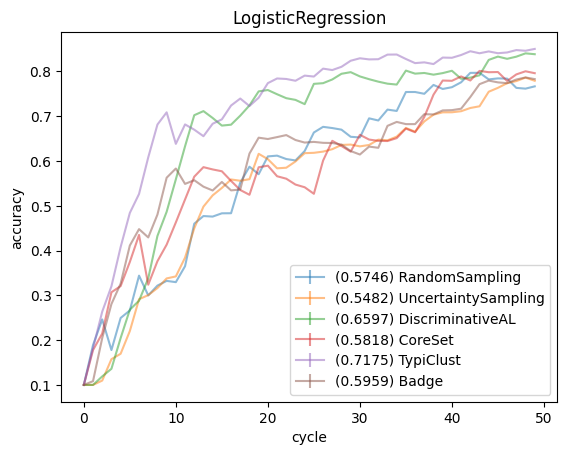

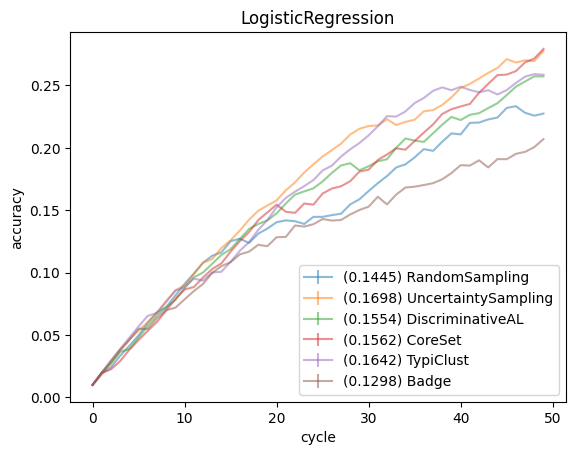

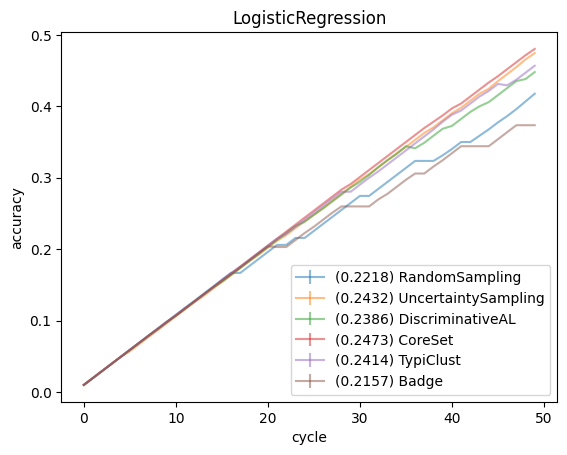

In [42]:
with mlflow.start_run():
    for data_name in dataset_names:
        for clf_name in classifier_names:
            for qs_name in query_strategy_names:
                key = (data_name, clf_name, qs_name)
                result = results[key]
                reshaped_result = result.reshape((-1, n_cycles))
                errorbar_mean = np.mean(reshaped_result, axis=0)
                mlflow.log_metric = (f'errorbar_mean for {qs_name} with {clf_name}', errorbar_mean)
                errorbar_std = np.std(reshaped_result, axis=0)
                mlflow.log_metric = (f'errorbar_std for {qs_name} with {clf_name}', errorbar_std)
                plt.errorbar(np.arange(n_cycles), errorbar_mean, errorbar_std, label=f"({np.mean(errorbar_mean):.4f}) {qs_name}", alpha=0.5)
            plt.title(clf_name)
            plt.legend(loc='lower right')
            plt.xlabel('cycle')
            plt.ylabel('accuracy')
            plt.show()